In [2]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from os.path import exists
import random

#GP
import sklearn
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import PredictionErrorDisplay


#LHC sampling 
from scipy.stats import qmc

#map
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

#homemade function file
import importlib
import ppe_loading_functions #as functions
importlib.reload(ppe_loading_functions)
import ref_data_functions #as functions
importlib.reload(ref_data_functions)


import matplotlib.colors as mcolors
mcolors.CSS4_COLORS

colors=['c', 'b', 'm', 'k', 'y', 'gray','lightcoral', 'dodgerblue', 'blueviolet']
shapes=['.', '*', '+', '>', '<', 's','-.', 'o']

# Load ICON PPEs

In [3]:
var1stPPE, results1stPPE,var2ndPPE, results2ndPPE, varMoreCloudParam, resultsMoreCloudParam,\
 varMoreCloudParam2, resultsMoreCloudParam2, varPhyDyn_NewParam_2tun,resultsPhyDyn_NewParam_2tun,\
 varPhyDyn_NewParam_5thPPE_2tun,results_5thPPE_2tun=\
ppe_loading_functions.load_all_ppes()

In [4]:
#Ref tuned ICON-A 2.6.4
pressure_addi,pressure_fact,tauufact,aes_glo_psl,aes_SOO_tauu,aes_NAO_tauu,aes_60N_1000hPa_ua,aes_60S_1000hPa_ua,\
aes_60N_10hPa_ua,aes_60S_10hPa_ua=ref_data_functions.ICON_aes_refdata()

In [5]:
#Physics Ref
ref_mean, ref_std=ref_data_functions.References_outputs()
#Dynamics Ref
refsERA5, refsMERRA2, refsERAInterim=ref_data_functions.References_Dynoutputs()

#all ref values for Physics and Dynamic variables
ref2tun_mean=np.zeros(9)
ref2tun_mean[0:5]=ref_mean #physics variables
ref2tun_mean[5:]=[refsERA5[0],refsERA5[1],refsERA5[2],refsERA5[3]] #dynamics variables
#ref_mean
print(ref2tun_mean)

#all std for Physics and Dynamic variables: not used yet in the HM flow

/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOALW=-file['gtoa_lw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarnin

[ 2.40866470e+02 -2.40114889e+02  5.00000000e-01  6.74343643e+01
  2.44086728e+01  1.09413767e+01  3.27732849e+01  2.94719753e-03
  1.36748120e-01]


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/iris/analysis/cartography.py:412: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [6]:
ref_Clt_ESACCI, ref_Clt_ESACCI_std, ref_Clt_CLARA_AVHRR, ref_Clt_CLARA_AVHRR_std=ref_data_functions.Ref_clt()
ref_Prw_ESACCI, ref_Prw_ERA5, ref_Prw_ERA5_std=ref_data_functions.Ref_prw()

In [7]:
years_clt_esacci,clt_esacci_per_year=ref_data_functions.clt_esacci_per_years()
years_clt_claraavhrr,clt_claraavhrr_per_year=ref_data_functions.clt_claraavhrr_per_years()
years_prw_era5,prw_era5_per_year=ref_data_functions.prw_era5_per_years()

In [8]:
#reference data 2nd tuning step
ref2tun_mean=ref_data_functions.era5_data()

/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOALW=-file['gtoa_lw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarnin

# GP

In [16]:
# train the GP on the training sample

results=np.concatenate((resultsMoreCloudParam,resultsMoreCloudParam2),axis=0) #phy
var1=np.concatenate((varMoreCloudParam,varMoreCloudParam2),axis=0)

kernel = 1 * Matern(length_scale=1.0, nu=1.5) #RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) #np.array([1.0,1.0,1.0])) #length_scale=10) # ,1.0,1.0,1.0]))#, length_scale_bounds=(1e-2, 1e2))
GP_MoreCloudParam = GaussianProcessRegressor(kernel=kernel,alpha=1e-5, n_restarts_optimizer=20)

#scale data https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
scaler_var1 = preprocessing.StandardScaler().fit(var1)
scaled_var1 = scaler_var1.transform(var1)

GP_MoreCloudParam.fit(scaled_var1, results) #
GP_MoreCloudParam.kernel_

score=cross_val_score(GP_MoreCloudParam, scaled_var1, results)
print('GP_MoreCloudParam, cross val score:', np.mean(score))#, "get_param",GP1.get_params())

GP_MoreCloudParam, cross val score: 0.8109890300590934


In [17]:
nparam=7
Nsize=100

CMFCTOP_VAR=np.linspace(0.01 , 0.2,Nsize) 
CPRCON_VAR=np.linspace(0.000015, 0.00035,Nsize) 
CCSAUT_VAR=np.linspace(0.2, 4,Nsize)
CSECFRL_VAR=np.linspace(1.0e-5, 10.0e-5,Nsize)
CVTFALL_VAR=np.linspace(0.2, 4,Nsize)
Pr_VAR=np.linspace(5e-1, 1.2,Nsize)
R0top_VAR=np.linspace(5e-1, 9e-1,Nsize)


def synthe_all(ii,indbounds):
    print(ii)
    if indbounds==0:    
        CMFCTOP_bounds = [0.01 ] #, 0.2,100) #
        CPRCON_bounds = [0.000015 ] #, 0.00035] #
        CCSAUT_bounds = [0.2]     #  , 4]
        CSECFRL_bounds = [1.0e-5] # , 10.0e-5] #
        CVTFALL_bounds = [0.2]    # , 4] #
        Pr_bounds      = [5e-1]   # , 1.2]
        R0top_bounds  = [5e-1]    # , 9e-1]
    if indbounds==1:    
        CMFCTOP_bounds = [0.02] #, 0.2,100) #
        CPRCON_bounds = [0.00035 ] #, 0.00035] #
        CCSAUT_bounds = [4]     #  , 4]
        CSECFRL_bounds = [10.0e-5] # , 10.0e-5] #
        CVTFALL_bounds = [4]    # , 4] #
        Pr_bounds      = [1.2]   # , 1.2]
        R0top_bounds  = [9e-1]    # , 9e-1]


    if ii==0:
        CMFCTOP_bounds=CMFCTOP_VAR 
    if ii==1:
        CPRCON_bounds=CPRCON_VAR 
    if ii==2:
        CCSAUT_bounds=CCSAUT_VAR
    if ii==3:
        CSECFRL_bounds=CSECFRL_VAR
    if ii==4:
        CVTFALL_bounds=CVTFALL_VAR
    if ii==5:
        Pr_bounds=Pr_VAR
    if ii==6:
        R0top_bounds=R0top_VAR

    nsimu=len(CMFCTOP_bounds)*len(CPRCON_bounds)*len(CCSAUT_bounds)*len(CSECFRL_bounds)*len(CVTFALL_bounds)*len(Pr_bounds)*len(R0top_bounds)
    synthe=np.zeros((nsimu,nparam,))
    isimu=0
    nzero=0
    for CMFCTOP_bounds_ in CMFCTOP_bounds:
        for CPRCON_bounds_ in CPRCON_bounds:
            for CCSAUT_bounds_ in CCSAUT_bounds:
                for CSECFRL_bounds_ in CSECFRL_bounds:
                    for CVTFALL_bounds_ in CVTFALL_bounds:
                        for Pr_bounds_ in Pr_bounds:
                            for R0top_bounds_ in R0top_bounds:
                                synthe[isimu,0]=CMFCTOP_bounds_
                                synthe[isimu,1]=CPRCON_bounds_
                                synthe[isimu,2]=CCSAUT_bounds_
                                synthe[isimu,3]=CSECFRL_bounds_
                                synthe[isimu,4]=CVTFALL_bounds_
                                synthe[isimu,5]=Pr_bounds_
                                synthe[isimu,6]=R0top_bounds_
                                isimu+=1
    return synthe

In [18]:
synthe_CMFCTOP0=synthe_all(0,0)
synthe_CPRCON0=synthe_all(1,0)
synthe_CCSAUT0=synthe_all(2,0)
synthe_CSECFRL0=synthe_all(3,0)
synthe_CVTFALL0=synthe_all(4,0)
synthe_Pr0=synthe_all(5,0)
synthe_R0top0=synthe_all(6,0)

synthe_alll0=[synthe_CMFCTOP0, synthe_CPRCON0, synthe_CCSAUT0, synthe_CSECFRL0, synthe_CVTFALL0, synthe_Pr0, synthe_R0top0]

synthe_CMFCTOP1=synthe_all(0,1)
synthe_CPRCON1=synthe_all(1,1)
synthe_CCSAUT1=synthe_all(2,1)
synthe_CSECFRL1=synthe_all(3,1)
synthe_CVTFALL1=synthe_all(4,1)
synthe_Pr1=synthe_all(5,1)
synthe_R0top1=synthe_all(6,1)

synthe_alll1=[synthe_CMFCTOP1, synthe_CPRCON1, synthe_CCSAUT1, synthe_CSECFRL1, synthe_CVTFALL1, synthe_Pr1, synthe_R0top1]

synthe_alll_sevbound=[synthe_alll0,synthe_alll1]

0
1
2
3
4
5
6
0
1
2
3
4
5
6


In [19]:
#large PPE used for the scaling fit
Nsizefit=5
CMFCTOP_VARfit=np.linspace(0.01 , 0.2,Nsizefit) 
CPRCON_VARfit=np.linspace(0.000015, 0.00035,Nsizefit) 
CCSAUT_VARfit=np.linspace(0.2, 4,Nsizefit)
CSECFRL_VARfit=np.linspace(1.0e-5, 10.0e-5,Nsizefit)
CVTFALL_VARfit=np.linspace(0.2, 4,Nsizefit)
Pr_VARfit=np.linspace(5e-1, 1.2,Nsizefit)
R0top_VARfit=np.linspace(5e-1, 9e-1,Nsizefit) 
nsimu=len(CMFCTOP_VARfit)*len(CPRCON_VARfit)*len(CCSAUT_VARfit)*len(CSECFRL_VARfit)*len(CVTFALL_VARfit)*len(Pr_VARfit)*len(R0top_VARfit)
synthefit=np.zeros((nsimu,nparam,))
isimu=0
nzero=0
for CMFCTOP_bounds_ in CMFCTOP_VARfit:
    for CPRCON_bounds_ in CPRCON_VARfit:
        for CCSAUT_bounds_ in CCSAUT_VARfit:
            for CSECFRL_bounds_ in CSECFRL_VARfit:
                for CVTFALL_bounds_ in CVTFALL_VARfit:
                    for Pr_bounds_ in Pr_VARfit:
                        for R0top_bounds_ in R0top_VARfit:
                            synthefit[isimu,0]=CMFCTOP_bounds_
                            synthefit[isimu,1]=CPRCON_bounds_
                            synthefit[isimu,2]=CCSAUT_bounds_
                            synthefit[isimu,3]=CSECFRL_bounds_
                            synthefit[isimu,4]=CVTFALL_bounds_
                            synthefit[isimu,5]=Pr_bounds_
                            synthefit[isimu,6]=R0top_bounds_
                            isimu+=1

In [20]:
def automatic_mean_std(ivar,indbounds):
    synthe_alll=synthe_alll_sevbound[indbounds]
    scaler_samplesynthe = preprocessing.StandardScaler().fit(synthefit)
    scaled_samplesynthe = scaler_samplesynthe.transform(synthe_alll[ivar])
    #print(scaled_samplesynthe)
    mean_samplesyn, std_samplesyn = GP_MoreCloudParam.predict(scaled_samplesynthe, return_std=True)

    return mean_samplesyn, std_samplesyn

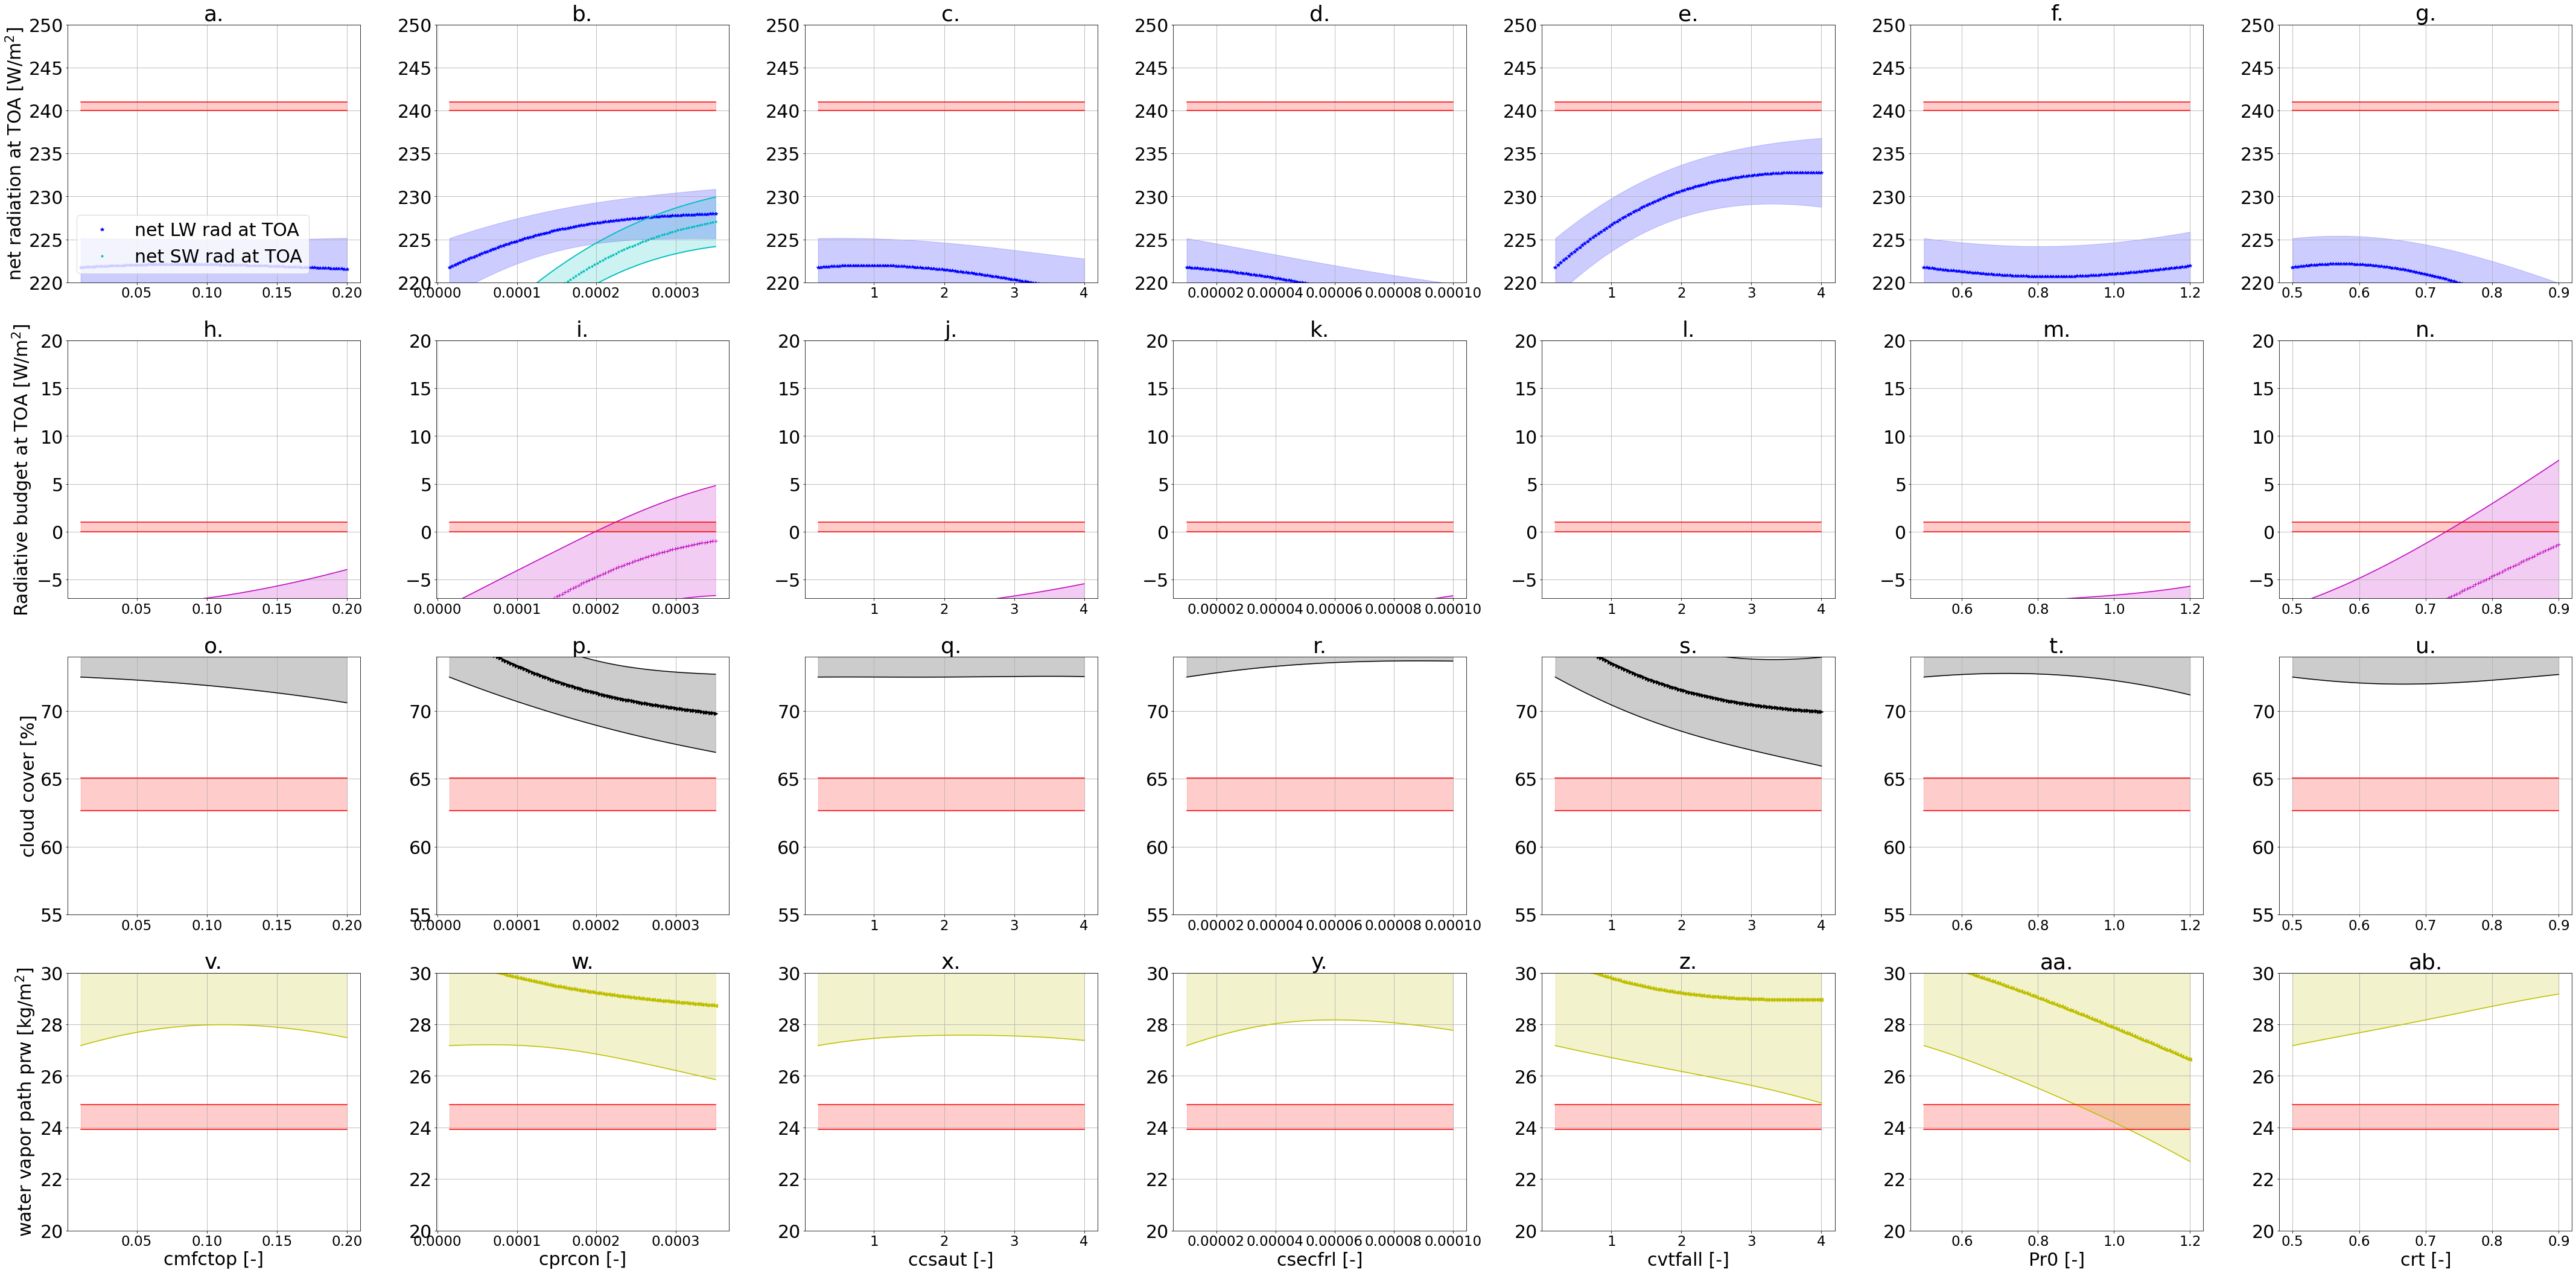

In [23]:
#Plot the new PPE to be ran: parameters and values of the outputs

fontsize=30
plt.rcParams["legend.fontsize"] = fontsize
plt.rc('font', size=fontsize) 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize-7
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['figure.figsize'] = [60, 30]

nn=8
N=1
#results=results_2ndPPE
trianglex = [ 240, 240, 241, 240 ] 
triangley = [ 240, 241, 241, 240 ]

#plt.fill(trianglex, triangley,'g',alpha=0.5,label='Ref. CERES and (Giorgetta et al. 2018)')
#plt.plot([240.8], [241.2], '^',color='orange')#,label='ICON-aes-1.3')
#plt.plot(-resultsMoreCloudParam[:,v1],resultsMoreCloudParam[:,v2],'>',color='g',label='ICON-A PPE more cloud param')

#labels=['synthe_CMFCTOP', 'synthe_CPRCON', 'synthe_CCSAUT', 'synthe_CSECFRL', 'synthe_CVTFALL', 'synthe_Pr', 'synthe_R0top']
labelsp=['cmfctop [-]', 'cprcon [-]', 'ccsaut [-]', 'csecfrl [-]', 'cvtfall [-]', 'Pr0 [-]', 'crt [-]'] #labelsp=['CMFCTOP', 'CPRCON', 'CCSAUT', 'CSECFRL', 'CVTFALL', 'Pr', 'R0top']
labelsoutputs=[r'net SW radiation at TOA [W/m$^2$]',r'net LW radiation at TOA [W/m$^2$]',r'net radiation at TOA [W/m$^2$]',r'cloud cover [%]',r'water vapor path prw [kg/m$^2$]']
labelsoutputsnodim=[r'net SW rad at TOA',r'net LW rad at TOA',r'Radiative budget at TOA ',r'cloud cover',r'water vapor path prw ']
titles=['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.','k.','l.','m.','n.','o.','p.','q.','r.','s.','t.','u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.']

colorsL=['c', 'b', 'm', 'k', 'y', 'gray','lightcoral', 'dodgerblue', 'blueviolet']
shapesL=['.', '*', '+', '>', '<', 's','-.', 'o']
shapestd='-'
colorref='r'
AA=0.2
whichparamval=[0]
FirstpartTitle='GP PPE results,'
meann0ALL={}
meann1ALL={}
stdd0ALL={}
stdd1ALL={}
for ivar in np.arange(0,7):
    meann0,stdd0 =automatic_mean_std(ivar,0)
    meann1,stdd1 =automatic_mean_std(ivar,1)
    meann0ALL[ivar]=meann0
    meann1ALL[ivar]=meann1
    stdd0ALL[ivar]=stdd0
    stdd1ALL[ivar]=stdd1
meannall=[meann0ALL,meann1ALL]
stddall=[stdd0ALL,stdd1ALL]

Ntotparam=7
fig = plt.figure()
for ivar in np.arange(0,Ntotparam):
    ccc=colors[ivar]

    v1=1
    v2=0
    v3=2
    ax = fig.add_subplot(4,Ntotparam,ivar+1)
    for indbounds in whichparamval:
        meann=meannall[indbounds][ivar]
        stdd=stddall[indbounds][ivar]
        synthe_alll=synthe_alll_sevbound[indbounds]
        
        ax.plot(synthe_alll[ivar][:,ivar],-meann[:,v1],shapesL[v1],color=colorsL[v1],label=labelsoutputsnodim[v1])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2],shapesL[v2],color=colorsL[v2],label=labelsoutputsnodim[v2])

        ax.fill_between(synthe_alll[ivar][:,ivar],-meann[:,v1]+stdd[:,v1],-meann[:,v1]-stdd[:,v1],alpha=AA,color=colorsL[v1])
        ax.fill_between(synthe_alll[ivar][:,ivar],meann[:,v2]+stdd[:,v2],meann[:,v2]-stdd[:,v2],alpha=AA,color=colorsL[v2])

        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2]+stdd[:,v2],shapestd,color=colors[v2])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2]-stdd[:,v2],shapestd,color=colors[v2])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2]+stdd[:,v2],shapestd,color=colors[v2])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2]-stdd[:,v2],shapestd,color=colors[v2])

        #plot reference values
        ax.fill_between([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[240,240],[241,241],alpha=AA,color=colorref)
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[240,240],'-',color=colorref)
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[241,241],'-',color=colorref)

    if ivar+1 in [1,8,15,22]:
        ax.set_ylabel(r'net radiation at TOA [W/m$^2$]')
        ax.legend(loc="lower left")
    if ivar+1 in [22,23,24,25,26,27,28]:
        ax.set_xlabel(labelsp[ivar])

    ax.set_ylim([220,250])
    ax.grid()
    ax.set_title(titles[ivar])

    ax = fig.add_subplot(4,Ntotparam,ivar+8)
    for indbounds in whichparamval:
        meann=meannall[indbounds][ivar]
        stdd=stddall[indbounds][ivar]
        synthe_alll=synthe_alll_sevbound[indbounds]
        
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v1]+meann[:,v2],shapesL[v3],color=colorsL[v3],label=labelsoutputs[v3])
        ax.fill_between(synthe_alll[ivar][:,ivar],meann[:,v1]+meann[:,v2]+stdd[:,v1]+stdd[:,v2],meann[:,v1]+meann[:,v2]-stdd[:,v1]-stdd[:,v2],alpha=AA,color=colorsL[v3])
        
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v1]+meann[:,v2]+stdd[:,v1]+stdd[:,v2],shapestd,color=colorsL[v3])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v1]+meann[:,v2]-stdd[:,v1]-stdd[:,v2],shapestd,color=colorsL[v3])

        #plot reference values
        ax.fill_between([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[0,0],[1,1],alpha=AA,color=colorref)
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[0,0],'-',color=colorref)
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[1,1],'-',color=colorref)

    
    if ivar+8 in [1,8,15,22]:
        ax.set_ylabel(r'Radiative budget at TOA [W/m$^2$]')
    if ivar+8 in [22,23,24,25,26,27,28]:
        ax.set_xlabel(labelsp[ivar])
    
    #ax.legend(loc="upper left")
    ax.set_ylim([-7,20])
    ax.grid()
    ax.set_title(titles[ivar+7])

    ax = fig.add_subplot(4,Ntotparam,ivar+15)
    v4=3
    #results=results_2ndPPE
    Ns=2

    for indbounds in whichparamval:
        meann=meannall[indbounds][ivar]
        stdd=stddall[indbounds][ivar]
        synthe_alll=synthe_alll_sevbound[indbounds]
        
        #plot reference values
        ax.fill_between([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_Clt_CLARA_AVHRR,ref_Clt_CLARA_AVHRR], [ref_Clt_ESACCI,ref_Clt_ESACCI],alpha=AA, color=colorref) #,label='Ref. CERES, ERA-Interim')
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_Clt_CLARA_AVHRR,ref_Clt_CLARA_AVHRR],'-', color=colorref) #,label='Ref. CERES, ERA-Interim')
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_Clt_ESACCI,ref_Clt_ESACCI],'-', color=colorref) #,label='Ref. CERES, ERA-Interim')
        
        #plt.plot([24.6], [63.6], '^',color='orange',label='ICON-aes-1.3')

        plt.plot(synthe_alll[ivar][:,ivar],meann[:,v4],shapesL[v4],color=colorsL[v4],label=labelsoutputs[v4])
        
        ax.fill_between(synthe_alll[ivar][:,ivar],meann[:,v4]+stdd[:,v4],meann[:,v4]-stdd[:,v4],alpha=AA,color=colorsL[v4])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v4]+stdd[:,v4],shapestd,color=colorsL[v4])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v4]-stdd[:,v4],shapestd,color=colorsL[v4])
        
    ax.set_ylim([55,74])
    ax.grid()
    
    if ivar+15 in [1,8,15,22]:
        ax.set_ylabel(labelsoutputs[v4] )
    if ivar+15 in [22,23,24,25,26,27,28]:
        ax.set_xlabel(labelsp[ivar])
    
    #ax.legend(loc='upper right')
    ax.set_title(titles[ivar+14])
    
    ax = fig.add_subplot(4,Ntotparam,ivar+22)
    v5=4

    for indbounds in whichparamval:
        meann=meannall[indbounds][ivar]
        stdd=stddall[indbounds][ivar]
        synthe_alll=synthe_alll_sevbound[indbounds]

        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v5],shapesL[v5],color=colorsL[v5],label=labelsoutputs[v5])

        ax.fill_between(synthe_alll[ivar][:,ivar],meann[:,v5]+stdd[:,v5],meann[:,v5]-stdd[:,v5],alpha=AA,color=colorsL[v5]) 
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v5]+stdd[:,v5],shapestd,color=colorsL[v5]) 
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v5]-stdd[:,v5],shapestd,color=colorsL[v5])
        
        #plot reference values
        ax.fill_between([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_mean[4]-Ns*ref_std[4],ref_mean[4]-Ns*ref_std[4]], [ref_mean[4]+Ns*ref_std[4],ref_mean[4]+Ns*ref_std[4]],alpha=AA, color=colorref) #,label='Ref. CERES, ERA-Interim')
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_mean[4]-Ns*ref_std[4],ref_mean[4]-Ns*ref_std[4]],'-', color=colorref) #,label='Ref. CERES, ERA-Interim')
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_mean[4]+Ns*ref_std[4],ref_mean[4]+Ns*ref_std[4]],'-', color=colorref) #,label='Ref. CERES, ERA-Interim')

    ax.set_title(titles[ivar+21])
    if ivar+22 in [1,8,15,22]:
        ax.set_ylabel(labelsoutputs[v5] )
    if ivar+22 in [22,23,24,25,26,27,28]:
        ax.set_xlabel(labelsp[ivar])
    
    #ax.legend(loc='upper left')
    ax.set_ylim([20,30])
    ax.grid()
fig.tight_layout()
plt.show()
#fig.savefig('PaperFig/Output_wrt_Param_addiParam_PhyOutputs.png')